<h1>Exploratory Data Analysis</h1>

Let's start by a few imports :

In [3]:
from sales_forecast import forecast_model
from numpy import linspace
import seaborn as sns
import matplotlib.pyplot as plt

We create the model, who imports the data, then sets some graphics parameters :

In [4]:
model = forecast_model()

print(model.stores.head())
print(model.features.head())

#TODO add the rest of graphic tuning
sns.set_style("darkgrid")

   ts_id Store                      SKU
0      0  3301     _Baltika №0 Can 0,45
1      1  3301     _Baltika №3 Can 0,45
2      2  3301     _Baltika №7 Can 0,45
3      3  3301  _Baltika №7 Bottle 0,47
4      4  3301     _Baltika №9 Can 0,45
                         SKU      Segment    Pack       Product      Brand  \
0        _Carlsberg Can 0,45   MainStream     Can         Lager  Carlsberg   
1   _Flash Up Energy PET 0,5  High Margin     PET  Energy-drink      Flash   
2       _Holsten Bottle 0,47      Premium  Bottle         Lager    Holsten   
3     _Tuborg Green Can 0,45      Premium     Can         Lager     Tuborg   
4  _Tuborg Green Bottle 0,48      Premium  Bottle         Lager     Tuborg   

   Volume  
0    0.45  
1    0.50  
2    0.50  
3    0.45  
4    0.50  


Let's plot a few time-series to see what's going on :

In [5]:
def plot_time_serie(model, index):
    data = model.train_data[model.train_data.ts_id == index]
    sns.lineplot(x="Date", y="Sales", data=data)
    plt.xticks(ticks=linspace(0, len(data.Date), 10), rotation=15)
    plt.title("Time-Serie of index {}".format(index))
    plt.show()

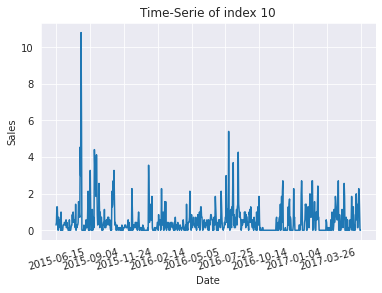

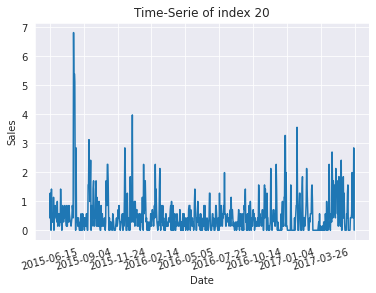

In [6]:
plot_time_serie(model, 10)
plot_time_serie(model, 20)


We can plot all the time-series of one particular store, to see if they all follow the same pattern :

In [ ]:
def plot_time_serie(model, index, ax=None):
    data = model.train_data[model.train_data.ts_id == index]
    #We retrieve the infos about this time-serie
    sku = model.stores['SKU'][index]
    store = model.stores['Store'][index]
    #feature_row = model.features.loc[model.features['SKU'] == sku]
    sns.lineplot(x="Date", y="Sales", data=data)
    plt.xticks(ticks=linspace(0, len(data.Date), 10), rotation=15)
    plt.title("Time-Serie of the {} in the store {}".format(sku, store))
    plt.show()


def plot_full_store_time_series(model, store):
    stores_data = model.stores.loc[model.stores['Store'] == store]
    time_series = stores_data['ts_id']
    f, ax = plt.subplots(len(time_series) // 2, 2, figsize=(12,6))
    for i, t_s in enumerate(time_series):
        l, col = i // 2, i % 2
        plot_time_serie(model, t_s, ax=ax[l, col])
    plt.show()

In [ ]:
plot_full_store_time_series(model, '3301')

In [ ]:
def plot_hist_sku(model, feature, hue=None):
    """Plot the histogram representing the distribution of sku across the features [Segment, Pack, Product], and cross it with another feature as color"""
    if feature not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect feature name. Should be one of these : "Segment", "Pack", "Product".""")
    if hue not in ["Segment", "Pack", "Product"]:
        raise ValueError("""Incorrect hue name. Should be one of these : "Segment", "Pack", "Product".""")
    sns.histplot(data=model.features, y=feature, hue=hue)
    plt.title("Types of " + feature)
    plt.show()

In [ ]:
plot_hist_sku(model, "Segment", hue="Pack")
plot_hist_sku(model, "Pack", hue="Product")
plot_hist_sku(model, "Product", hue="Segment")
